In [10]:
from catboost import Pool, CatBoostClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
import matplotlib.pyplot as plt

In [2]:
# !jupyter nbextension enable --py widgetsnbextension

Считываем предобработанные данные

In [3]:
path_to_val_data = "/home/kenny/avito_tech/data/processed/val_data.csv"
path_to_train_data = "/home/kenny/avito_tech/data/processed/train_data.csv"

In [4]:
df_test = pd.read_csv(path_to_val_data)
df_train = pd.read_csv(path_to_train_data)

In [4]:
df_test.sample(3)

,title,description,subcategory,category,price,region,city,datetime_submitted,is_bad,text,...,description_count_numbers,phone_normal,phone_strange,has_site,has_email,home_phone,phone_operators,messenger,filtered_text,filtered_numbers
5214,Утеплитель пеноплэкс 3см,"ПЕНОПЛЭКС КОМФОРТ 6682х282х20мм (1,82м4=0,4149...",Ремонт и строительство,Для дома и дачи,951.0,Татарстан,Казань,2019-10-11 14:22:46.397216,0,утеплитель пеноплэкс 3см пеноплэкс комфорт 668...,...,24,1,0,0,0,1,0,0,3 6682 282 20 1 82 4 0 4149 3 1 7 926,3 6682 282 20 1 82 4 0 4149 3 1 7 926
12363,"Игрушки,есть оригинальные и по мультикам","Продам игрушки:/\n- ""Герои Марвел"" + фигурка ...",Товары для детей и игрушки,Личные вещи,100.0,Омская область,Омск,2019-10-13 18:48:11.327520,0,игрушка оригинальный мультик продать игрушка г...,...,58,0,0,0,0,0,0,0,play doh 4 430 6 500 130 3 5 400 100 530 3 13...,4 430 6 500 130 3 5 400 100 530 3 130 2 100 7...
413,Штатное головное устройство на hyundai santafe,ПРОДАМ Штатное головное устройство на hyunda...,Запчасти и аксессуары,Транспорт,6000.0,Оренбургская область,Оренбург,2019-10-10 07:49:02.201855,1,штатный головной устройство hyundai santafe пр...,...,14,0,0,0,0,0,0,0,hyundai santafe hyundai santafe 1031 11 38 11...,1031 11 38 11 5000


Обучим модельку на всех признаках, за исключением:
    description
    title
    datetime_submitted

In [4]:
df_train.drop(['description', 'title', 'datetime_submitted'], axis=1, inplace=True)
df_test.drop(['description', 'title',  'datetime_submitted'], axis=1, inplace=True)

In [5]:
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=43, stratify=df_train['category'])

In [6]:
cat_features = ['subcategory', 'category', 'region', 'city']

train_pool = Pool(data=df_train.drop(['is_bad'], axis=1), cat_features=cat_features, label=df_train['is_bad'], text_features=['filtered_text', 'text', 'filtered_numbers'])
val_pool = Pool(data=df_val.drop(['is_bad'], axis=1), cat_features=cat_features, label=df_val['is_bad'], text_features=['filtered_text', 'text', 'filtered_numbers'])

In [11]:
from multiprocessing import cpu_count

catboost_basic = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    random_strength=0.01,
    depth=8,
    eval_metric='AUC',
    verbose=100,
    task_type='CPU',
    thread_count=cpu_count(),
)
catboost_basic.fit(train_pool, plot=True, eval_set=val_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8219566	best: 0.8219566 (0)	total: 1.67s	remaining: 27m 46s
100:	test: 0.9686253	best: 0.9686253 (100)	total: 2m 35s	remaining: 23m 5s
200:	test: 0.9738378	best: 0.9738378 (200)	total: 4m 52s	remaining: 19m 23s
300:	test: 0.9761323	best: 0.9761323 (300)	total: 7m 8s	remaining: 16m 36s
400:	test: 0.9778653	best: 0.9778653 (400)	total: 9m 25s	remaining: 14m 4s
500:	test: 0.9789033	best: 0.9789033 (500)	total: 11m 39s	remaining: 11m 36s
600:	test: 0.9797253	best: 0.9797253 (600)	total: 13m 54s	remaining: 9m 14s
700:	test: 0.9803130	best: 0.9803130 (700)	total: 16m 8s	remaining: 6m 53s
800:	test: 0.9807487	best: 0.9807487 (800)	total: 18m 21s	remaining: 4m 33s
900:	test: 0.9811514	best: 0.9811514 (900)	total: 20m 29s	remaining: 2m 15s
999:	test: 0.9814768	best: 0.9814768 (999)	total: 22m 37s	remaining: 0us

bestTest = 0.9814767641
bestIteration = 999



In [12]:
catboost_basic.save_model('/home/kenny/avito_tech/models/catboost/catboost_base_classifier.cbm')

In [7]:
basic_catboost = CatBoostClassifier().load_model('/home/kenny/avito_tech/models/catboost/catboost_base_classifier.cbm')

In [10]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from prettytable import PrettyTable

def _check_quality(df, model, cols_to_drop, target, text_features, cat_features):
    test_pool = Pool(data=df.drop(cols_to_drop, axis=1), cat_features=cat_features, label=df[target], text_features=text_features)
    df["predict_proba"] = model.predict_proba(test_pool)[:, 1]
    df["predict"] = model.predict(test_pool)
    categories = dict(df.category.value_counts())
    all_roc_auc = []
    all_f1 = []
    all_accuracy = []
    category_table = PrettyTable(["Category", "ROC-AUC", "Accuracy", "F1"])
    overall_table = PrettyTable(["ROC-AUC", "Accuracy", "F1"])
    for category in categories:
        tmp = df[df.category == category]
        predicted_y = tmp.predict
        predicted_proba_y = tmp.predict_proba
        true_y = tmp.is_bad
        
        roc_auc_category = roc_auc_score(true_y, predicted_proba_y)
        accuracy_category = accuracy_score(true_y, predicted_y)
        f1_category = f1_score(true_y, predicted_y)
        
        all_roc_auc.append(roc_auc_category)
        all_f1.append(f1_category)
        all_accuracy.append(accuracy_category)
        
        category_table.add_row([category, roc_auc_category, accuracy_category, f1_category])
    print("Category table:")
    print(category_table)
    print()
    # calculation for all roc_auc, f1, accuracy
    table = PrettyTable(["ROC-AUC", "Accuracy", "F1"])
    roc_auc = roc_auc_score(df[target], df["predict_proba"])
    f1 = f1_score(df[target], df["predict"])
    accuracy = accuracy_score(df[target], df["predict"])
    table.add_row([roc_auc, f1, accuracy])
    print("All values table:")
    print(table)
    print()
    # calculation for mean values for each metric type:
    mean_roc_auc = sum(all_roc_auc) / len(all_roc_auc)
    mean_f1 = sum(all_f1) / len(all_f1)
    mean_accuracy = sum(all_accuracy) / len(all_accuracy)
    overall_table.add_row([mean_roc_auc, mean_accuracy, mean_f1])
    print("Overall mean values table:")
    print(overall_table)

Проверим качество для тестового набора

In [9]:
cat_features = ['subcategory', 'category', 'region', 'city']
target= "is_bad"
text_features = ['filtered_text', 'text', 'filtered_numbers']
cols_to_drop = ["is_bad"]
_check_quality(df_test, basic_catboost, cols_to_drop, target, text_features, cat_features)

Category table:
+---------------------+--------------------+--------------------+--------------------+
|       Category      |      ROC-AUC       |      Accuracy      |         F1         |
+---------------------+--------------------+--------------------+--------------------+
|      Транспорт      | 0.9872654390930441 | 0.9519738038930325 | 0.9197568389057751 |
| Бытовая электроника | 0.9341419330289195 | 0.9551649928263989 | 0.6376811594202898 |
|   Для дома и дачи   | 0.9378757013091102 | 0.9290928050052137 | 0.7926829268292682 |
|     Личные вещи     | 0.8234548572280623 | 0.909915014164306  | 0.6168674698795179 |
|     Недвижимость    | 0.9312468338810449 | 0.8042117245304496 | 0.7627586206896552 |
|    Хобби и отдых    | 0.9305212075964724 | 0.9196988707653702 | 0.5616438356164384 |
|        Услуги       | 0.8881990897025945 | 0.8184523809523809 | 0.8087774294670848 |
|        Работа       | 0.9401054339010544 | 0.8419117647058824 | 0.8230452674897119 |
|     Для бизнеса     | 0.8

Посмотрим на feature_importance

In [11]:
basic_catboost.get_feature_importance(val_pool, type='LossFunctionChange', prettified=True)

,Feature Id,Importances
0,text,0.106470
1,filtered_numbers,0.028337
2,phone_normal,0.009292
3,description_count_numbers,0.007767
4,filtered_text,0.007576
5,description_len,0.005307
6,phone_strange,0.005037
7,home_phone,0.003336
8,has_site,0.001005
9,price,0.000901


In [ ]:
from sklearn.inspection import permutation_importance
X_test = df_val.drop("is_bad", axis=1)
y_test = df_val["is_bad"]
perm_importance = permutation_importance(basic_catboost, X_test, y_test, n_repeats=5, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance')

Попробуем исключить все признаки начиная с 9

In [5]:
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=43, stratify=df_train['category'])

In [6]:
df_train.drop(['description', 'category', 'title', 'subcategory', 'price', 'region', 'city', 'datetime_submitted', 'has_email', 'title_count_numbers', 'title_len', 'phone_operators', 'messenger'], axis=1, inplace=True)
df_val.drop(['description', 'category', 'title', 'subcategory', 'price', 'region', 'city', 'datetime_submitted', 'has_email', 'title_count_numbers', 'title_len', 'phone_operators', 'messenger'], axis=1, inplace=True)
df_test.drop(['description', 'title', 'subcategory', 'price', 'region', 'city', 'datetime_submitted', 'has_email', 'title_count_numbers', 'title_len', 'phone_operators', 'messenger'], axis=1, inplace=True)

In [7]:
train_pool = Pool(data=df_train.drop(['is_bad'], axis=1), label=df_train['is_bad'], text_features=['filtered_text', 'text', 'filtered_numbers'])
val_pool = Pool(data=df_val.drop(['is_bad'], axis=1), label=df_val['is_bad'], text_features=['filtered_text', 'text', 'filtered_numbers'])

In [11]:
from multiprocessing import cpu_count

catboost_modified = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    random_strength=0.01,
    depth=8,
    eval_metric='AUC',
    verbose=100,
    task_type='CPU',
    thread_count=cpu_count(),
)
catboost_modified.fit(train_pool, plot=True, eval_set=val_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.9248244	best: 0.9248244 (0)	total: 1.78s	remaining: 29m 36s
100:	test: 0.9686389	best: 0.9686389 (100)	total: 2m 22s	remaining: 21m 5s
200:	test: 0.9730219	best: 0.9730219 (200)	total: 4m 32s	remaining: 18m 2s
300:	test: 0.9752735	best: 0.9752735 (300)	total: 6m 41s	remaining: 15m 33s
400:	test: 0.9766920	best: 0.9766920 (400)	total: 8m 48s	remaining: 13m 9s
500:	test: 0.9776575	best: 0.9776576 (499)	total: 10m 56s	remaining: 10m 54s
600:	test: 0.9783457	best: 0.9783457 (600)	total: 12m 59s	remaining: 8m 37s
700:	test: 0.9789033	best: 0.9789033 (700)	total: 15m	remaining: 6m 24s
800:	test: 0.9793790	best: 0.9793790 (800)	total: 17m 1s	remaining: 4m 13s
900:	test: 0.9797503	best: 0.9797503 (900)	total: 18m 59s	remaining: 2m 5s
999:	test: 0.9800338	best: 0.9800338 (999)	total: 20m 52s	remaining: 0us

bestTest = 0.980033842
bestIteration = 999



In [15]:
cols_to_drop = ['category','is_bad']
cat_features = []
text_features = ['filtered_text', 'text', 'filtered_numbers']
target = "is_bad"
_check_quality(df_test, catboost_modified, cols_to_drop, target, text_features, cat_features)

Category table:
+---------------------+--------------------+--------------------+--------------------+
|       Category      |      ROC-AUC       |      Accuracy      |         F1         |
+---------------------+--------------------+--------------------+--------------------+
|      Транспорт      | 0.9888222100988058 | 0.9545206476259778 | 0.9244712990936556 |
| Бытовая электроника | 0.9390696347031964 | 0.9540889526542324 | 0.6595744680851063 |
|   Для дома и дачи   | 0.9488257710689584 | 0.9348279457768509 | 0.8125937031484258 |
|     Личные вещи     | 0.8376507187735102 | 0.9150141643059491 | 0.6376811594202899 |
|     Недвижимость    | 0.9453206385493655 | 0.8366533864541833 | 0.8098078197481776 |
|    Хобби и отдых    | 0.9367038402314405 | 0.9121706398996235 | 0.5783132530120482 |
|        Услуги       | 0.8797997701988938 | 0.8065476190476191 | 0.7818791946308725 |
|        Работа       | 0.8623817247904839 | 0.7941176470588235 | 0.7543859649122808 |
|     Для бизнеса     | 0.8

In [18]:
catboost_modified.save_model('/home/kenny/avito_tech/models/catboost/catboost_modified_classifier.cbm')

In [7]:
catboost_modified = CatBoostClassifier()
catboost_modified.load_model('/home/kenny/avito_tech/models/catboost/catboost_modified_classifier.cbm')

In [16]:
catboost_modified.get_feature_importance(val_pool, type='LossFunctionChange', prettified=True)

,Feature Id,Importances
0,text,0.115192
1,filtered_text,0.029891
2,phone_normal,0.011401
3,description_count_numbers,0.008023
4,phone_strange,0.007113
5,home_phone,0.006821
6,description_len,0.006800
7,filtered_numbers,0.004599
8,has_site,0.000414


Text(0.5, 1.0, 'Permutation Importance')

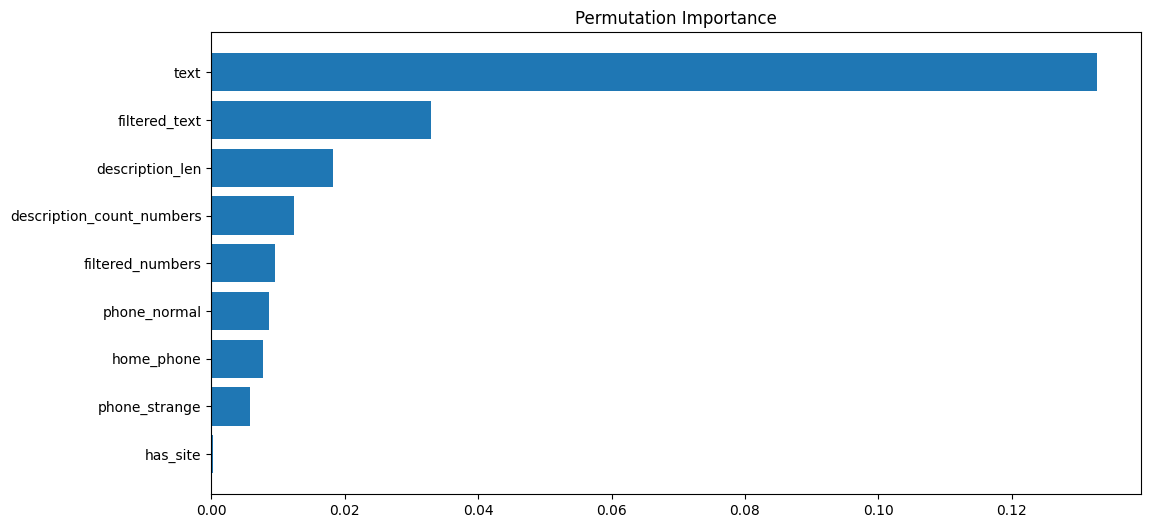

In [12]:
from sklearn.inspection import permutation_importance
X_test = df_val.drop("is_bad", axis=1)
y_test = df_val["is_bad"]
perm_importance = permutation_importance(catboost_modified, X_test, y_test, n_repeats=5, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance')